# Comparison: RandomForest with Oversampling vs Augmented Data

In this blog I'd like to show the difference deep tabular augmentation can have when training a Random Forest on a highly biased data base. In this case, we have a look at credit card fraud, where fraud itself is is way less represented than non-fraud. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
os.listdir()

['.ipynb_checkpoints',
 '2021-04-10-DeepLearning_TabularDataAugmentation.ipynb',
 '2_dep.gif',
 'DeepLearning_DataAugmentation_RF.ipynb',
 'Enquete_OD_2013_dom108_v3.csv',
 'Enquete_OD_2013_dom108_v3.xlsx',
 'GAN.ipynb',
 'gen_origines_test.pdf',
 'gen_origines_test.png',
 'od13_Regdomi8_7_CNORD.csv',
 'single_trip_animation.gif',
 'test_données.py',
 'Untitled.ipynb']

# Lecture des données

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fn = 'Enquete_OD_2013_dom108_v3.csv'

df = pd.read_csv(fn,delimiter=';')
df = df.drop(df[df.D_DESRMR ==0].index)
df = df.drop(df[df.D_ORIRMR ==0].index)

In [4]:
cols = ['P_SEXE','P_GRAGE','D_ORIXCOOR','D_ORIYCOOR','D_DESTXCOOR','D_DESTYCOOR','D_MODE1']
ncols = len(cols)
df = df[cols]

Pour utiliser toutes les données: ajouter une colonne uniforme d'utilisation

In [5]:
df = df.assign(use=[1,]*len(df))

Séparer les données en train et test sets: a partir d'ici, le code suit le modèle a https://github.com/siddhi47/deep_tabular_augmentation/blob/main/Notebooks/DeepLearning_DataAugmentation_RF.ipynb

In [159]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var = 'use', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_use = X_train_scaled[np.where(y_train==1)[0]]
X_test_use = X_test_scaled[np.where(y_test==1)[0]]

In [160]:
datasets = dta.create_datasets(X_train_use, y_train.values[np.where(y_train==1)], X_test_use, y_test.values[np.where(y_test==1)])
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024, device='cpu'))

Architecture du réseau de neurones:

In [170]:
D_in = X_train_use.shape[1]
VAE_arch = [50, 12, 12, 12]
target_name = 'use'
target_class = 1
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

Trouver le learning rate:

In [171]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

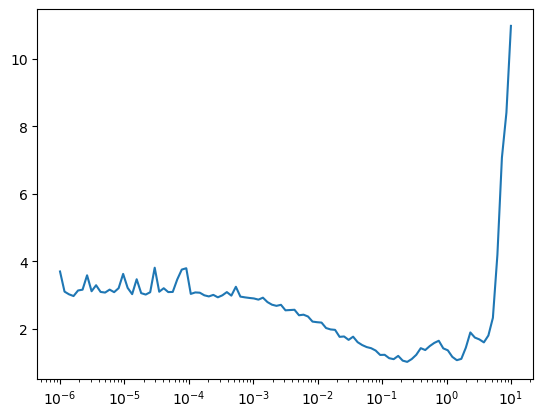

In [172]:
run.recorder.plot(skip_last=0)

In [173]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

Entrainement du modèle:

In [174]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 3.20219087600708
validation loss is: 1.1299586296081543
epoch: 100
train loss is: 1.1100252866744995
validation loss is: 0.9910005927085876
epoch: 150
train loss is: 1.0554790496826172
validation loss is: 0.9777437448501587
epoch: 200
train loss is: 1.037963628768921
validation loss is: 0.9735528826713562
epoch: 250
train loss is: 1.0291494131088257
validation loss is: 0.9713712334632874
epoch: 300
train loss is: 1.0235317945480347
validation loss is: 0.9699056148529053
epoch: 350
train loss is: 1.0196528434753418
validation loss is: 0.9688412547111511
epoch: 400
train loss is: 1.0169923305511475
validation loss is: 0.968098521232605


Let's have a look how train_loss vs val_loss develops:

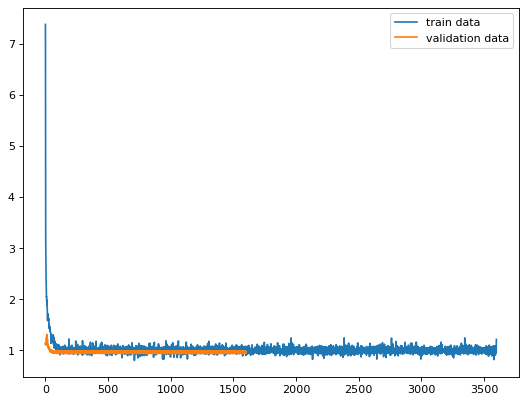

In [175]:
run.loss_tracker.plot_train_vs_val_loss()

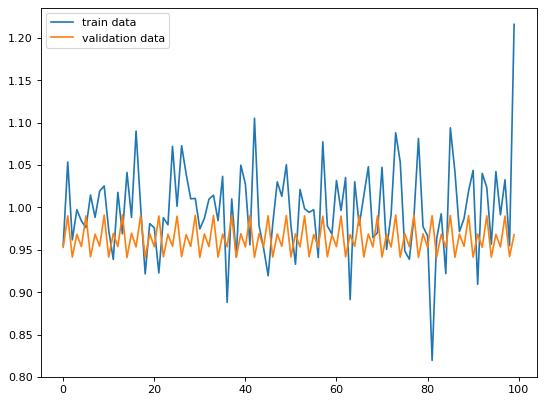

In [176]:
run.loss_tracker.plot_train_vs_val_loss_last_epochs(show_last=100)

Création de données depuis du bruit et examination des statistiques:

In [188]:
difference_in_class_occurences = 10000
df_fake = run.predict_df(learn, no_samples=difference_in_class_occurences, scaler=x_scaler)
std_list = list(df[df['use']==1][df_cols].std())
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=difference_in_class_occurences, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

,P_SEXE,P_GRAGE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
0,-0.281564,9.568690,293146.982961,5.039449e+06,295586.415322,5.046254e+06,-2.866739,1
1,1.620299,12.122972,296971.593007,5.048612e+06,300882.791670,5.047325e+06,5.127370,1
2,1.146218,8.535246,294754.917833,5.044898e+06,291932.287845,5.049081e+06,5.252027,1
3,0.902250,12.394481,293384.161674,5.047728e+06,291256.827186,5.038686e+06,5.403492,1
4,0.955229,12.285441,292900.701461,5.042363e+06,286441.310389,5.043232e+06,-1.329341,1


In [183]:
df_fake_with_noise.round().describe()

,P_SEXE,P_GRAGE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.0
mean,1.509300,9.037700,292758.716600,5.045054e+06,292690.864600,5.045089e+06,3.956500,1.0
std,0.585788,3.985407,4299.545014,3.589616e+03,4314.734079,3.550334e+03,4.614557,0.0
min,0.000000,-5.000000,276197.000000,5.029600e+06,275466.000000,5.031002e+06,-11.000000,1.0
25%,1.000000,6.000000,289840.000000,5.042648e+06,289765.500000,5.042680e+06,1.000000,1.0
50%,2.000000,9.000000,292768.500000,5.045033e+06,292659.500000,5.045133e+06,4.000000,1.0
75%,2.000000,12.000000,295719.250000,5.047478e+06,295605.250000,5.047444e+06,7.000000,1.0
max,4.000000,26.000000,309405.000000,5.058816e+06,308587.000000,5.059174e+06,23.000000,1.0


In [184]:
df.describe()

,P_SEXE,P_GRAGE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
count,12038.000000,12038.000000,12038.000000,1.203800e+04,12038.000000,1.203800e+04,12038.000000,12038.0
mean,1.512045,9.016697,292705.017445,5.045085e+06,292722.462203,5.045081e+06,3.985795,1.0
std,0.499876,3.974556,4315.119422,3.568503e+03,4328.020823,3.556616e+03,4.623595,0.0
min,1.000000,2.000000,261500.000000,5.016500e+06,261500.000000,5.016500e+06,1.000000,1.0
25%,1.000000,6.000000,290500.000000,5.043500e+06,291500.000000,5.043500e+06,1.000000,1.0
50%,2.000000,9.000000,292500.000000,5.045500e+06,292500.000000,5.045500e+06,2.000000,1.0
75%,2.000000,12.000000,293500.000000,5.046500e+06,293500.000000,5.046500e+06,4.000000,1.0
max,2.000000,16.000000,326500.000000,5.099500e+06,326500.000000,5.099500e+06,18.000000,1.0


Certaines entrées n'ont pas de sens: il faut arrondir les valeurs pour qu'elles soient des variables discrètes (entiers) représentant les différentes classes, par exemple, le groupe d'âge doit être un entier entre 1 et 15. On exclut également les valeurs hors des minimums et maximums des données originales.

In [192]:
df_fake_with_noise = df_fake_with_noise.round()


for col in df_fake_with_noise.columns:
    min = np.min(df[col])
    max = np.max(df[col])
    df_fake_with_noise = df_fake_with_noise[df_fake_with_noise[col]>=min]
    df_fake_with_noise = df_fake_with_noise[df_fake_with_noise[col]<=max]
df_fake_with_noise


,P_SEXE,P_GRAGE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
1,2.0,12.0,296972.0,5048612.0,300883.0,5047325.0,5.0,1
2,1.0,9.0,294755.0,5044898.0,291932.0,5049081.0,5.0,1
3,1.0,12.0,293384.0,5047728.0,291257.0,5038686.0,5.0,1
5,2.0,14.0,290773.0,5044547.0,286784.0,5046067.0,5.0,1
6,1.0,10.0,292302.0,5041885.0,296884.0,5043665.0,3.0,1
...,...,...,...,...,...,...,...,...
9995,2.0,15.0,301741.0,5040241.0,294602.0,5036621.0,8.0,1
9996,2.0,11.0,293414.0,5051457.0,292247.0,5048850.0,7.0,1
9997,1.0,7.0,296008.0,5047322.0,289022.0,5039972.0,10.0,1
9998,2.0,11.0,297078.0,5043738.0,284037.0,5043594.0,10.0,1


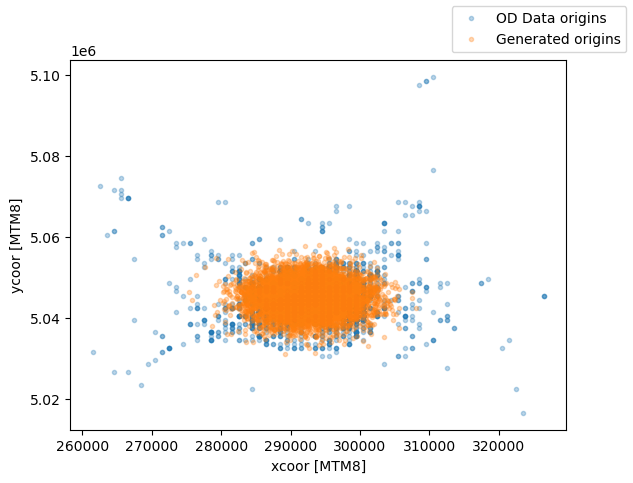

In [195]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('xcoor [MTM8]')
ax.set_ylabel('ycoor [MTM8]')
ax.plot(df.D_ORIXCOOR,df.D_ORIYCOOR,'.',alpha = 0.3, label = 'OD Data origins')
ax.plot(df_fake_with_noise.D_ORIXCOOR,df_fake_with_noise.D_ORIYCOOR,'.',alpha = 0.3, label = 'Generated origins')
fig.legend()

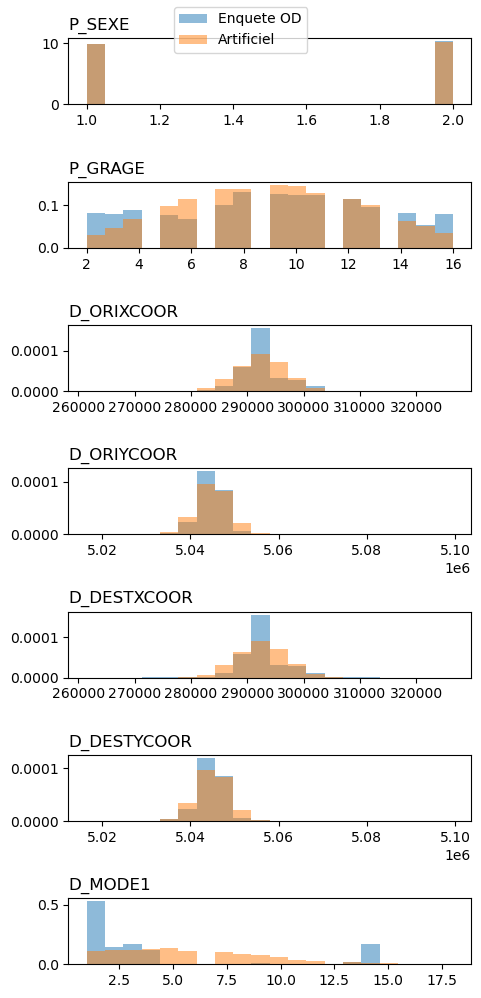

In [194]:
fig, ax = plt.subplots(len(df.columns)-1,1, figsize = (5,10))

for i in range(len(df.columns)-1):
    n,bins,_ = ax[i].hist(df[df.columns[i]], density = True, alpha = 0.5,bins = 20)
    ax[i].hist(df_fake_with_noise[df_fake_with_noise.columns[i]],density = True,alpha = 0.5,bins = bins)
    ax[i].set_title(df.columns[i],loc = 'left')
fig.legend(['Enquete OD','Artificiel'], loc = 'upper center')
fig.tight_layout()
fig.savefig('Figures/distributions.png',dpi = 200)

Sélection d'un sous-ensemble basé sur des conditions

In [147]:
subset = df_fake_with_noise[(df_fake_with_noise['P_GRAGE']==3) & (df_fake_with_noise['P_SEXE']==2)].sample(4)

,P_SEXE,P_GRAGE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1,use
538,2.0,3.0,292789.0,5037502.0,292703.0,5049227.0,10.0,1
872,2.0,3.0,287564.0,5052866.0,294740.0,5049033.0,4.0,1
808,2.0,3.0,295596.0,5054630.0,298578.0,5037482.0,9.0,1
383,2.0,3.0,287083.0,5040431.0,285984.0,5042229.0,8.0,1
